### Import libraries 

In [3]:
#import libraries for eda, cleaning and model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from collections import defaultdict
import nltk
from nltk.corpus import wordnet as wn
from nltk import pos_tag
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,recall_score,precision_score
from sklearn.naive_bayes import MultinomialNB
from string import punctuation

### Load Dataset

In [4]:
reviews = pd.read_csv('Assignment text mining - data clothing reviews.csv')
reviews.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [5]:
reviews['Class Name'].value_counts()

Dresses           6319
Knits             4843
Blouses           3097
Sweaters          1428
Pants             1388
Jeans             1147
Fine gauge        1100
Skirts             945
Jackets            704
Lounge             691
Swim               350
Outerwear          328
Shorts             317
Sleep              228
Legwear            165
Intimates          154
Layering           146
Trend              119
Casual bottoms       2
Chemises             1
Name: Class Name, dtype: int64

### Start with Dresses

In [7]:
df = reviews.loc[reviews['Class Name'] == 'Dresses']
df['Class Name'].value_counts()

Dresses    6319
Name: Class Name, dtype: int64

In [8]:
df=df.dropna()
df['Class Name'].value_counts()

Dresses    5371
Name: Class Name, dtype: int64

In [9]:
df=df[['Review Text','Rating']]
df=df.rename(columns={"Review Text": "text", "Rating": "rating", "Recommended IND": "index"})
df.head(10)

,text,rating
2,I had such high hopes for this dress and reall...,3
5,"I love tracy reese dresses, but this one is no...",2
8,I love this dress. i usually get an xs but it ...,5
9,"I'm 5""5' and 125 lbs. i ordered the s petite t...",5
10,Dress runs small esp where the zipper area run...,3
12,More and more i find myself reliant on the rev...,5
14,This is a nice choice for holiday gatherings. ...,3
19,I love the look and feel of this tulle dress. ...,5
21,"I'm upset because for the price of the dress, ...",4
22,"First of all, this is not pullover styling. th...",2


Text(0, 0.5, 'samples')

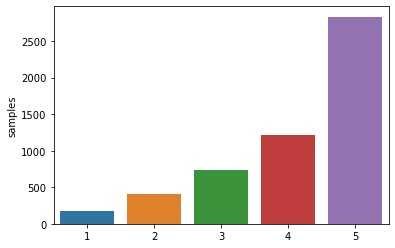

In [17]:
x=df['rating'].value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

convert ratings to positive(>3) and negative(<4)

In [18]:
from pandas.api.types import is_numeric_dtype
is_numeric_dtype(df['rating'])

df.loc[df.rating >=4 , "rating"] = "positive"
df.loc[df.rating != "positive", "rating"] = "negative"

df.head(10)

,text,rating
2,high hopes dress really wanted work me initial...,negative
5,love tracy reese dresses one petite feet tall...,negative
8,love dress usually get xs runs little snug bus...,positive
9,im lbs ordered petite make sure length long ...,positive
10,dress runs small esp zipper area runs ordered ...,negative
12,find reliant reviews written savvy shoppers pa...,positive
14,nice choice holiday gatherings like length gra...,negative
19,love look feel tulle dress looking something d...,positive
21,im upset price dress thought embroidered no pr...,positive
22,first all pullover styling side zipper purchas...,negative


Cleaning the dataset

In [19]:
df.iloc[1]['text']

'love tracy reese dresses one petite  feet tall usually wear p brand dress pretty package lot dress skirt long full overwhelmed small frame stranger alterations shortening narrowing skirt would take away embellishment garment love color idea style work me returned dress'

In [20]:
df['text']=df['text'].str.lower()
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df.head()

,text,rating
2,high hopes dress really wanted work initially ...,negative
5,love tracy reese dresses one petite feet tall ...,negative
8,love dress usually get xs runs little snug bus...,positive
9,im lbs ordered petite make sure length long ty...,positive
10,dress runs small esp zipper area runs ordered ...,negative


In [21]:
def remove_special_characters(text):
    pattern=r'[^a-zA-Z\s]'
    text=re.sub(pattern,'',text)
    return text
def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)

df['text'] = df['text'].apply(remove_special_characters)
df['text'] = df['text'].apply(strip_punctuation)

In [22]:
df.head(10)

,text,rating
2,high hopes dress really wanted work initially ...,negative
5,love tracy reese dresses one petite feet tall ...,negative
8,love dress usually get xs runs little snug bus...,positive
9,im lbs ordered petite make sure length long ty...,positive
10,dress runs small esp zipper area runs ordered ...,negative
12,find reliant reviews written savvy shoppers pa...,positive
14,nice choice holiday gatherings like length gra...,negative
19,love look feel tulle dress looking something d...,positive
21,im upset price dress thought embroidered print...,positive
22,first pullover styling side zipper purchased k...,negative


### CountVectorizer via Sklearn

create a dictionary from a series of texts. Shrink the text and mark it using space and slide as a space between words. I use a list of repetitive English words ("paused words") that cannot be counted: they are not informative enough.

convert the text to Unicode via .values.astype('U').

In [23]:
from sklearn.feature_extraction.text import CountVectorizer #The CountVectorizer object

text = df['text'].values.astype('U') #Taking the text from the df. We need to convert it to Unicode
vect = CountVectorizer(stop_words='english') #Create the CV object, with English stop words
vect = vect.fit(text) #We fit the model with the words from the review text
feature_names = vect.get_feature_names() #Get the words from the vocabulary
print(f"There are {len(feature_names)} words in the vocabulary. A selection: {feature_names[500:520]}")

There are 8725 words in the vocabulary. A selection: ['badly', 'badso', 'baffled', 'bag', 'baggage', 'baggier', 'bagginess', 'bagging', 'baggish', 'baggy', 'baggybig', 'baglike', 'bags', 'bahamas', 'bailey', 'baily', 'bainbridge', 'balance', 'balanced', 'balances']


By turning it into a dictionary,  I create a document-feature matrix, with documents (reviews) in the rows, and features (words) in the columns.

In [24]:
docu_feat = vect.transform(text) # make a matrix

In [27]:
print(docu_feat[0:1000,0:1000])

  (1, 210)	1
  (1, 466)	1
  (1, 884)	1
  (4, 341)	1
  (5, 591)	1
  (6, 661)	1
  (8, 466)	1
  (8, 661)	1
  (8, 685)	1
  (8, 859)	1
  (9, 475)	1
  (10, 313)	1
  (11, 253)	1
  (11, 587)	2
  (12, 173)	1
  (12, 587)	1
  (12, 901)	1
  (13, 211)	1
  (13, 648)	1
  (13, 661)	1
  (14, 93)	1
  (14, 108)	1
  (14, 932)	1
  (15, 685)	1
  (17, 811)	1
  :	:
  (987, 849)	1
  (989, 820)	1
  (990, 141)	1
  (990, 587)	1
  (991, 355)	1
  (991, 591)	1
  (991, 685)	2
  (991, 695)	1
  (991, 849)	1
  (992, 695)	1
  (992, 996)	1
  (994, 820)	1
  (995, 351)	1
  (995, 414)	1
  (995, 648)	1
  (995, 695)	1
  (995, 874)	1
  (995, 983)	1
  (996, 71)	1
  (996, 645)	1
  (996, 849)	1
  (997, 351)	1
  (998, 849)	1
  (999, 180)	1
  (999, 747)	1


### Naïve Bayes classifier from sklearn.

In [28]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB() #create the model
X = docu_feat #the document-feature matrix is the X matrix
y = df['rating'] #creating the y vector

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) #split the data and store it

nb = nb.fit(X_train, y_train) #fit the model X=features, y=character

#Evaluate the model
y_test_p = nb.predict(X_test)
nb.score(X_test, y_test)

0.8486352357320099

The accuracy is 84.8%,

In [29]:
y_test_p

array(['positive', 'negative', 'positive', ..., 'positive', 'positive',
       'positive'], dtype='<U8')

### Creating a confusion matrix

In [175]:
nb.classes_

array(['negative', 'positive'], dtype='<U8')

In [30]:
cm = confusion_matrix(y_test, y_test_p)
cm = pd.DataFrame(cm, index=['negative', 'positive'], columns=['negative pred', 'positive pred'])
cm

,negative pred,positive pred
negative,225,181
positive,63,1143


In [31]:
df['rating_pred'] = pd.Series(y_test_p)
df.head(10)

,text,rating,rating_pred
2,high hopes dress really wanted work initially ...,negative,positive
5,love tracy reese dresses one petite feet tall ...,negative,negative
8,love dress usually get xs runs little snug bus...,positive,positive
9,im lbs ordered petite make sure length long ty...,positive,positive
10,dress runs small esp zipper area runs ordered ...,negative,negative
12,find reliant reviews written savvy shoppers pa...,positive,positive
14,nice choice holiday gatherings like length gra...,negative,positive
19,love look feel tulle dress looking something d...,positive,positive
21,im upset price dress thought embroidered print...,positive,positive
22,first pullover styling side zipper purchased k...,negative,negative


Check out 3 cases where your model is off target.<br>There is much more positive rating in the data set and it affects on the prediction. so if we just predict one of the labels positive or negative, we could increase the accouracy.<br> also in bag of words some words occure more in positive ratings but rating is negative and viceversa. 

In [33]:
df_off=df.query('rating != rating_pred')
df_off.head()

,text,rating,rating_pred
2,high hopes dress really wanted work initially ...,negative,positive
14,nice choice holiday gatherings like length gra...,negative,positive
23,cute little dress fits tts little high waisted...,negative,positive
69,really wanted work alas strange fit straps wou...,negative,positive
87,debated n think looks loose model tighten look...,positive,negative


In [34]:
df['rating'].value_counts()

positive    4045
negative    1326
Name: rating, dtype: int64